In [11]:
import cv2
import math
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
#from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from random import randint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.utils import plot_model

In [47]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-kc_0nhym
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-kc_0nhym
  Resolved https://github.com/rcmalli/keras-vggface.git to commit 719ad75625fe51436b9a9479114b3d136847e11a


In [51]:
!pip install keras_vggface

In [9]:
members = ['uemura_rina', 'ozeki_rika', 'koike_minami', 'kobayashi_yui', 'saito_fuyuka',
         'sugai_yuka', 'habu_miduho', 'harada_aoi', 'moriya_akane', 'watanabe_rika', 'watanabe_risa',
         'inoue_rina', 'endo_hikari', 'oozono_rei', 'oonuma_akiho', 'kousaka_marino', 'seki_yumiko',
         'takemoto_yui', 'tamura_hono', 'fuziyoshi_karin', 'masumoto_kira', 'matuda_rina','morita_hikaru',
         'moriya_rena', 'yamasaki_ten']
base_dir = './face/'

In [2]:
members_label = {member_name:i for i, member_name in enumerate(members)}

In [3]:
members_label

{'uemura_rina': 0,
 'ozeki_rika': 1,
 'koike_minami': 2,
 'kobayashi_yui': 3,
 'saito_fuyuka': 4,
 'sugai_yuka': 5,
 'habu_miduho': 6,
 'harada_aoi': 7,
 'moriya_akane': 8,
 'watanabe_rika': 9,
 'watanabe_risa': 10,
 'inoue_rina': 11,
 'endo_hikari': 12,
 'oozono_rei': 13,
 'oonuma_akiho': 14,
 'kousaka_marino': 15,
 'seki_yumiko': 16,
 'takemoto_yui': 17,
 'tamura_hono': 18,
 'fuziyoshi_karin': 19,
 'masumoto_kira': 20,
 'matuda_rina': 21,
 'morita_hikaru': 22,
 'moriya_rena': 23,
 'yamasaki_ten': 24}

In [12]:
def make_image_dataset(base_dir):
    Images = []
    Labels = []
    label = 0
    for label_name in os.listdir(base_dir):
        label = members_label[label_name]
        for image_file in os.listdir(base_dir + label_name):
            image = cv2.imread(base_dir + label_name + '/' + image_file)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            Images.append(image_rgb)
            Labels.append(label)
    return shuffle(Images, Labels, random_state=397209)

In [13]:
def get_class_label(class_code):
    class_labels = {i:member_name for i, member_name in enumerate(members)}
    return class_labels[class_code]

In [14]:
Images, Labels = make_image_dataset(base_dir)

error: OpenCV(4.5.1) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [9]:
Images = np.array(Images)
Labels = np.array(Labels)
Images= Images.astype("float32")
Images /= 255

In [ ]:
Images = np.arra

In [10]:
Images.shape, Labels.shape

((11331, 128, 128, 3), (11331,))

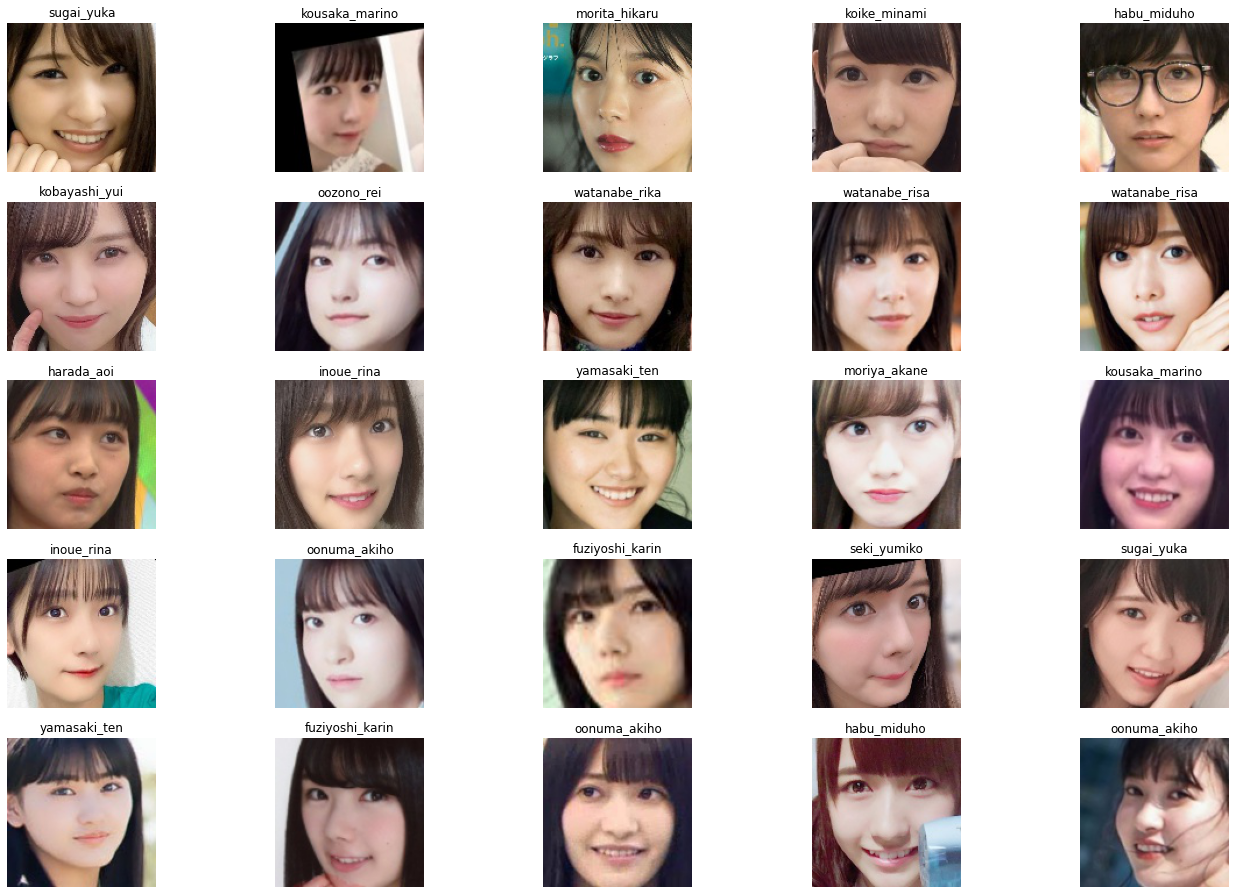

In [11]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_class_label(Labels[rnd_number]))
        ax[i,j].axis('off')

In [11]:
FOLD_NUM = 5
IMAGE_SIZE = 128
BATCH_SIZE = 32
n_categories = len(members)
epochs = 35
kfold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=25792)

valid_scores = []
models = []

In [33]:
for fold, (train_idx, valid_idx) in enumerate(kfold.split(Images, Labels)):
    X_train, X_valid = Images[train_idx], Images[valid_idx]
    y_train, y_valid = Labels[train_idx], Labels[valid_idx]
    
    data_generator = ImageDataGenerator(rotation_range=180,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
    data_generator.fit(X_train)
    y_train = to_categorical(y_train, n_categories)
    y_valid = to_categorical(y_valid, n_categories)
    
    vgg16_model = VGG16(weights='imagenet', 
                    include_top = False,
                    input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model = Sequential(vgg16_model.layers)

    for layer in model.layers[:15]:
        layer.trainable = False
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_categories, activation = 'softmax'))
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=10, 
                                   verbose=1, 
                                   mode= 'auto')
    
    model_checkpoint = ModelCheckpoint(f'model_{fold}.hdf5',
                                       monitor = 'val_loss',
                                       verbose = 0,
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'auto')
    
    steps_per_epoch = X_train.shape[0] / BATCH_SIZE
    model.fit_generator(data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, model_checkpoint])
    
    score = model.evaluate(X_valid, y_valid)
    
    print(f'fold{fold}log_loss: {score[1]}')
    valid_scores.append(score[1])
    
    models.append(model)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
141/141 [==============================] - 48s 289ms/step - loss: 3.2940 - accuracy: 0.0709 - val_loss: 3.1712 - val_accuracy: 0.0626
Epoch 2/20
141/141 [==============================] - 37s 262ms/step - loss: 3.0373 - accuracy: 0.1238 - val_loss: 3.0618 - val_accuracy: 0.1641
Epoch 3/20
141/141 [==============================] - 37s 262ms/step - loss: 2.8911 - accuracy: 0.1700 - val_loss: 2.9051 - val_accuracy: 0.1610
Epoch 4/20
141/141 [==============================] - 37s 263ms/step - loss: 2.7674 - accuracy: 0.2029 - val_loss: 2.8018 - val_accuracy: 0.1747
Epoch 5/20
141/141 [==============================] - 37s 261ms/step - loss: 2.6398 - accuracy: 0.2405 - val_loss: 2.7101 - val_accuracy: 0.1972
Epoch 6/20
141/141 [==============================] - 36s 256ms/step - loss: 2.5219 - accuracy: 0.2736 - val_loss: 2.5467 - val_accuracy: 0.2598
Epoch 7/20
141/141 [==============================] - 37s 260ms/step - loss: 2.4343 - accuracy: 0.2936 - val_loss: 2.3014 - val_ac

KeyboardInterrupt: 

In [28]:
model.evaluate(X_train, y_train)

284/284 [==============================] - 21s 75ms/step - loss: 1.1268 - accuracy: 0.6635


[1.126832365989685, 0.6635039448738098]

In [30]:
score = model.evaluate(X_valid, y_valid)

71/71 [==============================] - 6s 78ms/step - loss: 1.4033 - accuracy: 0.6034


In [31]:
score[1]

0.6034406423568726

In [122]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir("tensor_log"):
        os.mkdir("tensor_log")
    json_name = "architecture.json"
    open(os.path.join("tensor_log", json_name),"w").write(json_string)

In [ ]:
save_model(model)

In [143]:
def build_model():
    vgg16_model = VGG16(weights='imagenet', 
                    include_top = False,
                    input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model = Sequential(vgg16_model.layers)

    for layer in model.layers[:15]:
        layer.trainable = False
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_catefories, activation = 'softmax'))
    return model

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    Images, Labels, test_size=0.30, random_state=239995, stratify=Labels) 

y_train = to_categorical(y_train, n_categories)
y_valid = to_categorical(y_valid, n_categories)

In [13]:
input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
ResNet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [14]:
top_model = Sequential()
top_model.add(Flatten(input_shape = ResNet50.output_shape[1:]))
top_model.add(Dense(1024, activation = 'relu'))
top_model.add(Dense(256, activation = 'relu'))
top_model.add(Dense(128, activation = 'relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_categories, activation = 'softmax'))

In [15]:
full_model = Model(inputs = ResNet50.input, outputs = top_model(ResNet50.output))

In [16]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
full_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                   loss = 'categorical_crossentropy',
                   metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=10, 
                                   verbose=1, 
                                   mode= 'auto')
    
model_checkpoint = ModelCheckpoint('model.hdf5',
                                       monitor = 'val_loss',
                                       verbose = 0,
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'auto')

In [20]:
steps_per_epoch = X_train.shape[0] / BATCH_SIZE
history = full_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                         batch_size = BATCH_SIZE, epochs = epochs, verbose = 1,
                         steps_per_epoch=steps_per_epoch,
                         callbacks = [early_stopping, model_checkpoint])

Epoch 1/35
247/247 [==============================] - 85s 313ms/step - loss: 3.1359 - accuracy: 0.1009 - val_loss: 3.8423 - val_accuracy: 0.0506
Epoch 2/35
247/247 [==============================] - 74s 299ms/step - loss: 2.4208 - accuracy: 0.2996 - val_loss: 3.5774 - val_accuracy: 0.0391
Epoch 3/35
247/247 [==============================] - 74s 300ms/step - loss: 1.5345 - accuracy: 0.5511 - val_loss: 3.1046 - val_accuracy: 0.1215
Epoch 4/35
247/247 [==============================] - 74s 300ms/step - loss: 0.8539 - accuracy: 0.7568 - val_loss: 2.3647 - val_accuracy: 0.3762
Epoch 5/35
247/247 [==============================] - 74s 300ms/step - loss: 0.4527 - accuracy: 0.8735 - val_loss: 1.0029 - val_accuracy: 0.7294
Epoch 6/35
247/247 [==============================] - 74s 300ms/step - loss: 0.2505 - accuracy: 0.9262 - val_loss: 1.5250 - val_accuracy: 0.6347
Epoch 7/35
247/247 [==============================] - 74s 300ms/step - loss: 0.1929 - accuracy: 0.9448 - val_loss: 0.9628 - val_ac

In [21]:
train_score = full_model.evaluate(X_train, y_train, batch_size = BATCH_SIZE)

248/248 [==============================] - 19s 78ms/step - loss: 3.3646e-04 - accuracy: 0.9999


In [22]:
val_score = full_model.evaluate(X_valid, y_valid, batch_size = BATCH_SIZE)

107/107 [==============================] - 8s 77ms/step - loss: 0.6985 - accuracy: 0.8862


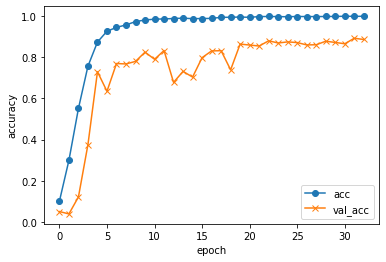

In [23]:
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

In [24]:
#モデルを保存
full_model.save("my_model.h5")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


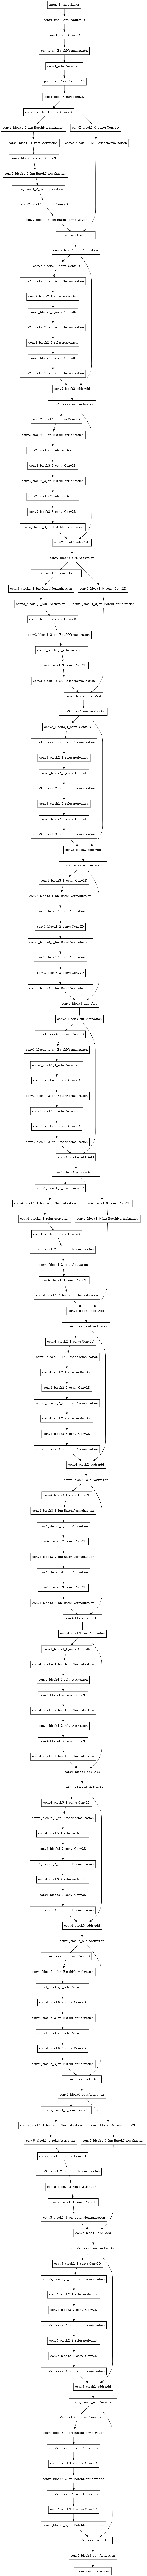

In [26]:
plot_model(full_model, to_file='model.png')